# GEQIE Multidimensional FRQI (MFRQI) Example

This is the example notebook that presents how to use GEQIE framework for encoding an image into its quantum representation using MFRQI method [(Li et al., 2014)](https://link.springer.com/article/10.1007/s11128-013-0705-7).

## Setup

### Imports

In [1]:
from pathlib import Path

import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from itertools import product

In [2]:
import geqie
from geqie.encodings import mfrqi

### Helper Functions

In [ ]:
def add_wire_grid(fig, xs, ys, zs, color="black", width=2, dash="dash"):
    # Each entry describes:
    # (axis_name, iterable1, iterable2, fixed_axis, range_min, range_max)
    axes = [
        ("x", ys, zs, "y,z", xs[0], xs[-1]),  # X-direction lines
        ("y", xs, zs, "x,z", ys[0], ys[-1]),  # Y-direction lines
        ("z", xs, ys, "x,y", zs[0], zs[-1]),  # Z-direction lines
    ]

    for axis, a1, a2, _, start, end in axes:
        for u, v in product(a1, a2):
            if axis == "x":
                x = [start, end]; y = [u, u];       z = [v, v]
            elif axis == "y":
                x = [u, u];       y = [start, end]; z = [v, v]
            else:  # axis == "z"
                x = [u, u];       y = [v, v];       z = [start, end]

            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode="lines",
                line=dict(color=color, width=width, dash=dash),
                showlegend=False
            ))


def plot_3d_image(image, title="3D Image Visualization", draw_grid=True):
    """Draws the cube for a 3D image using Plotly. Each voxel is represented as a square marker.
    May be slow for large images due to the number of grids (set `draw_grid` to `False` to disable).
    """

    x, y, z = np.indices(image.shape)
    fig = go.Figure(data=go.Scatter3d(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        mode="markers+text",
        marker=dict(
            symbol="square",
            size=12,
            line=dict(color="black", width=2),
            color=image.flatten(),
            colorscale="Greys",
            cmin=0,
            cmax=255,
            colorbar=dict(
                title="Pixel Value", 
                tickvals=[0, 64, 128, 192, 255],
                ticktext=["0", "64", "128", "192", "255"]
            ),
        ),
        text=image.flatten(),
        textposition="top center",
        showlegend=False,
    ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(showbackground=False, dtick=1),
            yaxis=dict(showbackground=False, dtick=1),
            zaxis=dict(showbackground=False, dtick=1),
        ),
        scene_camera=dict(eye=dict(x=2, y=1, z=1)),
        margin=dict(l=0, r=0, b=20, t=40)
    )

    if draw_grid:
        add_wire_grid(fig, x.flatten(), y.flatten(), z.flatten())

    return fig


## Encoding

### Displaying the image

Creating a test single-channel image $2 \times 2 \times 2$ and normalizing its pixel values to $[0.0, 1.0]$.

In [4]:
IMAGE_PATH = Path("../../assets/test_images/3d/image_0_2x2x2.npy")

image = np.load(IMAGE_PATH)
image

array([[[  0,  32],
        [ 64,  96]],

       [[128, 160],
        [192, 224]]])

In [5]:
plot_3d_image(image, title="Visualization of the 2x2x2 image", draw_grid=True)

### Encoding using unitary gate

In [6]:
circuit = geqie.encode(mfrqi.init_function, mfrqi.data_function, mfrqi.map_function, image, image_dimensionality=3)
circuit.draw(output="text")

»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
   q_3: »
        »
meas: 4/»
        »
«        ┌──────────────────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                                             ├»
«        │                                                                                              │»
«   q_1: ┤1                                                                                             ├»
«        │  Initialize(0.35355,0,0.35355,0,0.35355,0,0.35355,0,0.35355,0,0.35355,0,0.35355,0,0.35355,0) │»
«   q_2: ┤2                                                                                             ├»
«        │                                                                                              │»
«   q_3: ┤3                                                                                             ├»
«        └──────────────────────────────────────────────────────────────────────────────────────────────┘»
«meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                        »
«        ┌──────────┐ ░ ┌─┐         
«   q_0: ┤0         ├─░─┤M├─────────
«        │          │ ░ └╥┘┌─┐      
«   q_1: ┤1         ├─░──╫─┤M├──────
«        │  Unitary │ ░  ║ └╥┘┌─┐   
«   q_2: ┤2         ├─░──╫──╫─┤M├───
«        │          │ ░  ║  ║ └╥┘┌─┐
«   q_3: ┤3         ├─░──╫──╫──╫─┤M├
«        └──────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/════════════════╩══╩══╩══╩═
«                        0  1  2  3

### Simulating the circuit

The stemplot represents the number of results for each possible quantum state of the system with decimal basis where, e.g., $\ket{13} \equiv \ket{01101}$.

Text(0, 0.5, 'n_results')

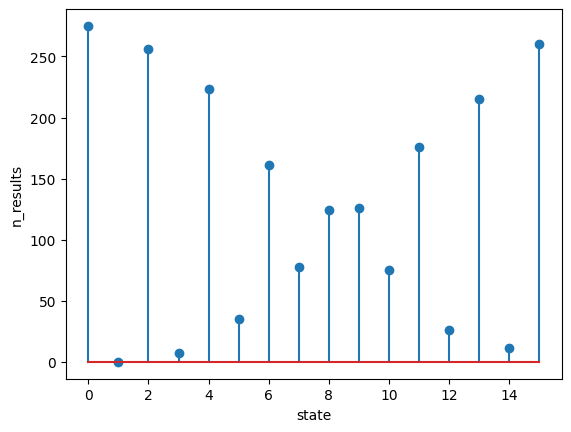

In [9]:
result = geqie.simulate(circuit, 2048, return_padded_counts=True)
plt.stem(result.values())
plt.xlabel("state")
plt.ylabel("n_results")

## Retrieving the image

In [ ]:
retrieved_image = mfrqi.retrieve_function(result, image_dimensionality=3)
plot_3d_image(retrieved_image, title="Retrieved 3D Image")

In [12]:
plot_3d_image(image, title="Original 3D Image")